In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
import sgm
from pkgs.MindEyeV2.src.generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenOpenCLIPEmbedder2
from pkgs.MindEyeV2.src.generative_models.sgm.models.diffusion import DiffusionEngine
from pkgs.MindEyeV2.src.generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import pkgs.MindEyeV2.src.utils as utils
from pkgs.MindEyeV2.src.models import *

import lovely_tensors as lt
lt.monkey_patch()

from csng.data import get_dataloaders
from csng.utils.mix import seed_all
from csng.utils.data import crop

DATA_PATH_BRAINREADER = os.path.join(os.environ["DATA_PATH"], "brainreader")
DATA_PATH_MINDEYE = os.path.join(os.environ["DATA_PATH"], "mindeye")
DATA_PATH_MINDEYE_CACHE = os.path.join(DATA_PATH_MINDEYE, "cache")
print(f"{DATA_PATH_BRAINREADER=}\n{DATA_PATH_MINDEYE=}\n{DATA_PATH_MINDEYE_CACHE=}")

# accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
# device = accelerator.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

!nvidia-smi

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


DATA_PATH_BRAINREADER='/scratch/izar/sobotka/csng/brainreader'
DATA_PATH_MINDEYE='/scratch/izar/sobotka/csng/mindeye'
DATA_PATH_MINDEYE_CACHE='/scratch/izar/sobotka/csng/mindeye/cache'
device: cuda
Fri Apr  4 01:25:23 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   40C    P0              26W / 250W |      0

## Configuration

In [2]:
# Load pretrained model ckpt
model_name = "csng_mouse_v1__03-04-25_16-06"
tag = "best"
print(f"\n---loading {model_name}:{tag} ckpt---\n")
checkpoint = torch.load(f"{DATA_PATH_MINDEYE}/train_logs/{model_name}/{tag}.pth", map_location='cpu')
state_dict = checkpoint['model_state_dict']
cfg = checkpoint['cfg']
evals_dir = cfg["model"]["evalsdir"]
outdir = cfg["model"]["outdir"]
assert os.path.exists(outdir)
os.makedirs(evals_dir, exist_ok=True)
cfg


---loading csng_mouse_v1__03-04-25_16-06:best ckpt---



{'device': 'cuda',
 'data_type': torch.float32,
 'seed': 0,
 'data': {'mixing_strategy': 'parallel_min',
  'max_training_batches': None,
  'mouse_v1': {'dataset_fn': 'sensorium.datasets.static_loaders',
   'dataset_config': {'paths': ['/scratch/izar/sobotka/csng/mouse_v1_sensorium22/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'],
    'normalize': True,
    'z_score_responses': True,
    'scale': 0.25,
    'include_behavior': False,
    'add_behavior_as_channels': False,
    'include_eye_position': True,
    'exclude': None,
    'file_tree': True,
    'cuda': False,
    'batch_size': 8,
    'drop_last': True,
    'use_cache': False},
   'skip_train': False,
   'skip_val': False,
   'skip_test': False,
   'normalize_neuron_coords': True,
   'average_test_multitrial': True,
   'save_test_multitrial': True,
   'test_batch_size': 7,
   'device': 'cuda',
   'batch_size': 8}},
 'wandb': {'project': 'MindEye', 'group': 'mindeye'},
 'data_name': 'mouse_v1',
 'crop_wins': 

## Data

In [3]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch=cfg["model"]["clip_img_embedder_arch"],
    version=cfg["model"]["clip_img_embedder_version"],
    output_tokens=True,
    only_tokens=True,
    cache_dir=cfg["model"]["cache_dir"],
)
clip_img_embedder.to(cfg["device"])

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


In [4]:
if cfg["model"]["blurry_recon"]:
    from diffusers import AutoencoderKL
    autoenc = AutoencoderKL(**cfg["model"]["autoenc"])
    ckpt = torch.load(f'{cfg["model"]["cache_dir"]}/sd_image_var_autoenc.pth')
    autoenc.load_state_dict(ckpt)
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(cfg["device"])
    utils.count_params(autoenc)

param counts:
83,653,863 total
0 trainable


In [5]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    
    def forward(self, x):
        return x
        
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out

model = MindEyeModule()
model.ridge = RidgeRegression(cfg["model"]["num_voxels_list"], out_features=cfg["model"]["hidden_dim"])

In [6]:
from pkgs.MindEyeV2.src.models import BrainNetwork

model.backbone = BrainNetwork(**cfg["model"]["brainnetwork"]) 
utils.count_params(model.ridge)
utils.count_params(model.backbone)
utils.count_params(model)

# setup diffusion prior network
prior_network = PriorNetwork(**cfg["model"]["prior_network"])

model.diffusion_prior = BrainDiffusionPrior(net=prior_network, **cfg["model"]["brain_diffusion_prior"])
model.to(cfg["device"])

utils.count_params(model.diffusion_prior)
utils.count_params(model)

param counts:
6,430,464 total
6,430,464 trainable
param counts:
345,356,284 total
345,356,284 trainable
param counts:
351,786,748 total
351,786,748 trainable
param counts:
220,955,800 total
220,955,784 trainable
param counts:
572,742,548 total
572,742,532 trainable


572742532

In [7]:
# Load pretrained model ckpt
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
del checkpoint

In [8]:
# setup text caption networks
from transformers import AutoProcessor, AutoModelForCausalLM
from pkgs.MindEyeV2.src.modeling_git import GitForCausalLMClipEmb

processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-large-coco")
# clip_text_model.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.to("cpu") # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.eval().requires_grad_(False)
cfg["model"]["clip_text_seq_dim"] = 257
cfg["model"]["clip_text_emb_dim"] = 1024

class CLIPConverter(torch.nn.Module):
    def __init__(self):
        super(CLIPConverter, self).__init__()
        self.linear1 = nn.Linear(cfg["model"]["clip_seq_dim"], cfg["model"]["clip_text_seq_dim"])
        self.linear2 = nn.Linear(cfg["model"]["clip_emb_dim"], cfg["model"]["clip_text_emb_dim"])

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x
        
clip_convert = CLIPConverter()
state_dict = torch.load(f"{cfg['model']['cache_dir']}/bigG_to_L_epoch8.pth", map_location='cpu')['model_state_dict']
clip_convert.load_state_dict(state_dict, strict=True)
# clip_convert.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_convert.to("cpu") # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
del state_dict

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# prep unCLIP
from omegaconf import OmegaConf
from copy import deepcopy

config = OmegaConf.load("src/generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
cfg["model"]["unclip"] = deepcopy(config)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(
    network_config=network_config,
    denoiser_config=denoiser_config,
    first_stage_config=first_stage_config,
    conditioner_config=conditioner_config,
    sampler_config=sampler_config,
    scale_factor=scale_factor,
    disable_first_stage_autocast=disable_first_stage_autocast
)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(cfg["device"])

ckpt_path = f'{cfg["model"]["cache_dir"]}/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

batch={"jpg": torch.randn(1,3,1,1).to(cfg["device"]), # jpg doesnt get used, it's just a placeholder
      "original_size_as_tuple": torch.ones(1, 2).to(cfg["device"]) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(cfg["device"])}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(cfg["device"])
print("vector_suffix", vector_suffix.shape)

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


In [10]:
### select a subject to test on
subj_name = "subj21067-10-18"
data_tier = "test"
# if "data_name" not in cfg:
#     cfg["data_name"] = "mouse_v1"
#     cfg["crop_wins"] = {
#         "mouse_v1": (22, 36),
#         "cat_v1": (20, 20),
#         "brainreader_mouse": None,
#     }
subj_list_idx = list(cfg["model"]["num_voxels"].keys()).index(subj_name)

seed_all(cfg["seed"])
dls, _ = get_dataloaders(config=cfg)
test_dl = dls[data_tier][cfg["data_name"]].dataloaders[subj_list_idx]
data_key = dls[data_tier][cfg["data_name"]].data_keys[subj_list_idx]
assert (f'subj{data_key}' == subj_name or f'subj0{data_key}' == subj_name)

voxels = {subj_name: []}
images = []
for b_i, batch in enumerate(test_dl):
    images.append(batch.images.cpu())
    voxels[subj_name].append(batch.responses.cpu())
images = torch.cat(images, dim=0)
voxels = {k: torch.cat(v, dim=0) for k,v in voxels.items()}
print(f"{subj_name=}\n{images=}\n{voxels[subj_name]=}")

subj_name='subj21067-10-18'
images=tensor[100, 1, 36, 64] n=230400 (0.9Mb) x∈[-1.750, 2.261] μ=0.118 σ=0.954
voxels[subj_name]=tensor[100, 8372] n=837200 (3.2Mb) x∈[1.491e-10, 21.902] μ=0.297 σ=0.527


In [11]:
img_tform = transforms.Compose([
    transforms.Lambda(lambda x: crop(x, cfg["crop_wins"][cfg["data_name"]])),
    # transforms.Resize((224, 224), antialias=True),
    # transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1)),
])

  0%|                     | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is sitting down.']


/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


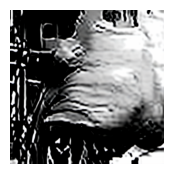

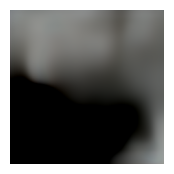

  1%|▏            | 1/100 [00:14<23:30, 14.25s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large group of people.']


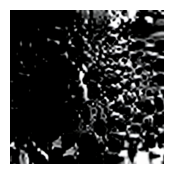

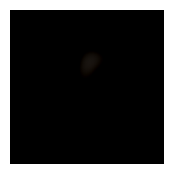

  2%|▎            | 2/100 [00:25<20:29, 12.55s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large building with a clock on it.']


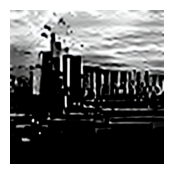

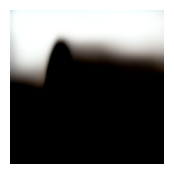

  3%|▍            | 3/100 [00:37<19:56, 12.33s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in front of a building.']


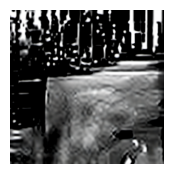

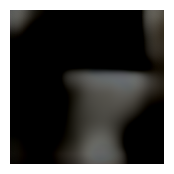

  4%|▌            | 4/100 [00:49<19:43, 12.32s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person standing in a field.']


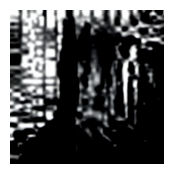

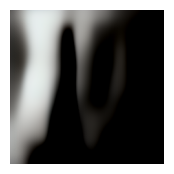

  5%|▋            | 5/100 [01:01<19:05, 12.06s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


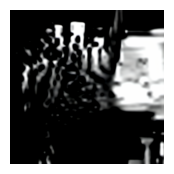

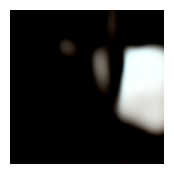

  6%|▊            | 6/100 [01:12<18:31, 11.82s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a small black and white photo of a person.']


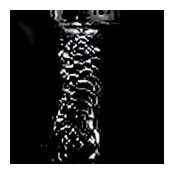

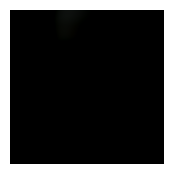

  7%|▉            | 7/100 [01:25<18:34, 11.98s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


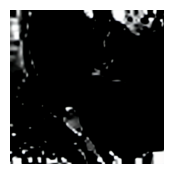

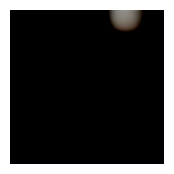

  8%|█            | 8/100 [01:36<18:04, 11.79s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in front of a building.']


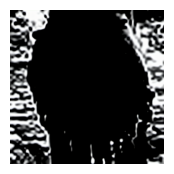

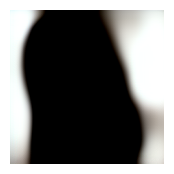

  9%|█▏           | 9/100 [01:48<18:01, 11.88s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a person.']


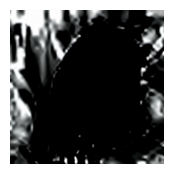

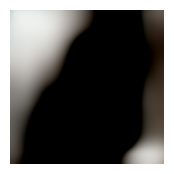

 10%|█▏          | 10/100 [02:00<17:55, 11.95s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white bird.']


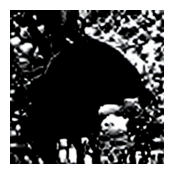

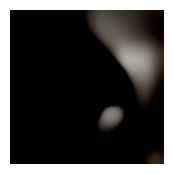

 11%|█▎          | 11/100 [02:12<17:34, 11.85s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person standing in front of a building.']


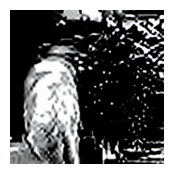

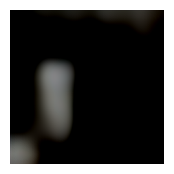

 12%|█▍          | 12/100 [02:24<17:29, 11.93s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a person.']


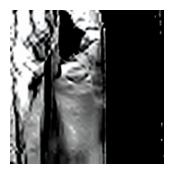

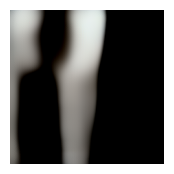

 13%|█▌          | 13/100 [02:36<17:22, 11.98s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white bird.']


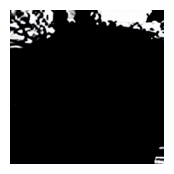

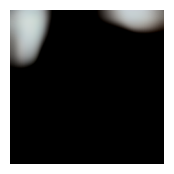

 14%|█▋          | 14/100 [02:48<17:01, 11.87s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white head of a man.']


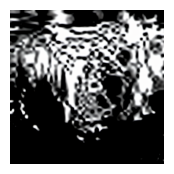

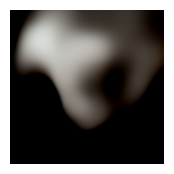

 15%|█▊          | 15/100 [03:00<17:01, 12.02s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a car parked on the side of a road.']


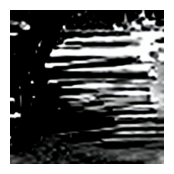

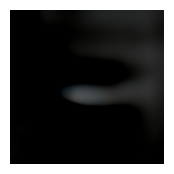

 16%|█▉          | 16/100 [03:13<16:58, 12.13s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


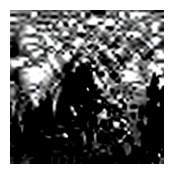

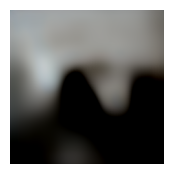

 17%|██          | 17/100 [03:24<16:28, 11.91s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in front of a building.']


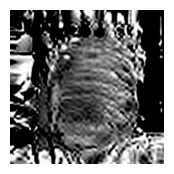

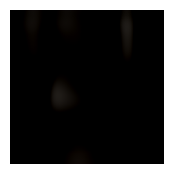

 18%|██▏         | 18/100 [03:36<16:27, 12.04s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large white and black bird.']


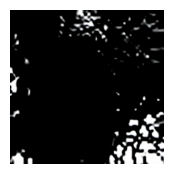

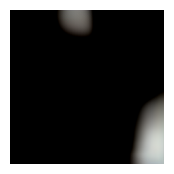

 19%|██▎         | 19/100 [03:48<16:05, 11.92s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man in a hat.']


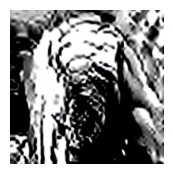

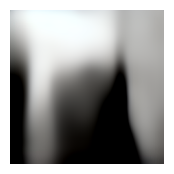

 20%|██▍         | 20/100 [03:59<15:41, 11.77s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


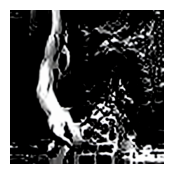

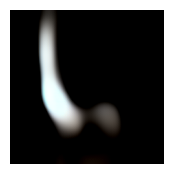

 21%|██▌         | 21/100 [04:11<15:21, 11.66s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large, black and white image of a man.']


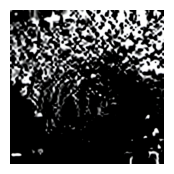

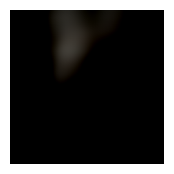

 22%|██▋         | 22/100 [04:23<15:31, 11.94s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in a field.']


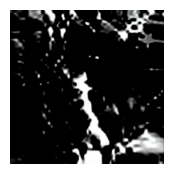

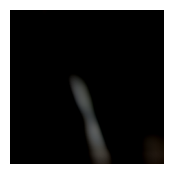

 23%|██▊         | 23/100 [04:35<15:19, 11.94s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a group of people.']


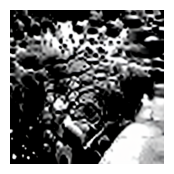

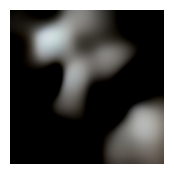

 24%|██▉         | 24/100 [04:46<14:50, 11.71s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in front of a building.']


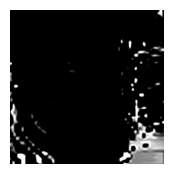

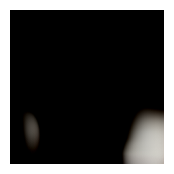

 25%|███         | 25/100 [04:59<14:53, 11.91s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a tall tree.']


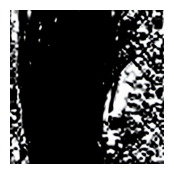

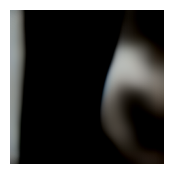

 26%|███         | 26/100 [05:10<14:20, 11.62s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


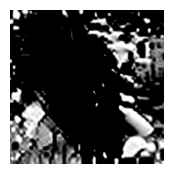

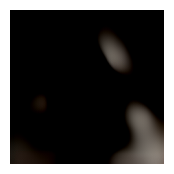

 27%|███▏        | 27/100 [05:21<14:04, 11.57s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in a field.']


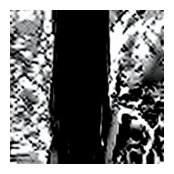

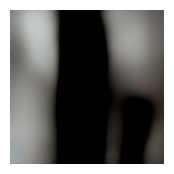

 28%|███▎        | 28/100 [05:33<13:56, 11.62s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large white and black cat.']


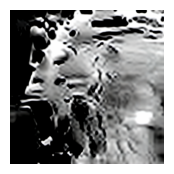

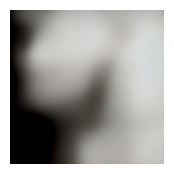

 29%|███▍        | 29/100 [05:45<13:46, 11.63s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a person.']


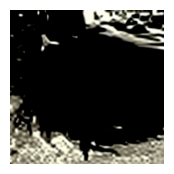

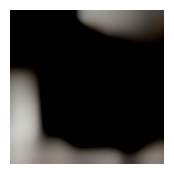

 30%|███▌        | 30/100 [05:57<13:45, 11.79s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white image of a person.']


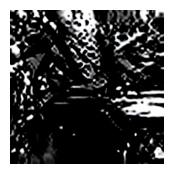

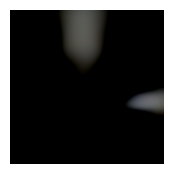

 31%|███▋        | 31/100 [06:09<13:48, 12.01s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


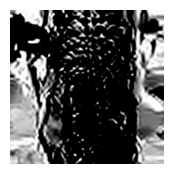

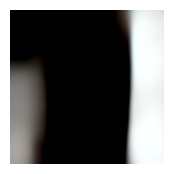

 32%|███▊        | 32/100 [06:21<13:25, 11.84s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in a field.']


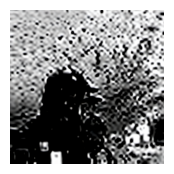

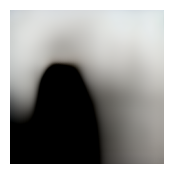

 33%|███▉        | 33/100 [06:32<13:11, 11.81s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is sitting down.']


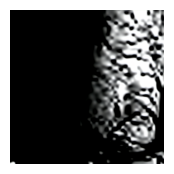

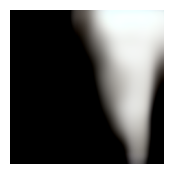

 34%|████        | 34/100 [06:44<12:52, 11.70s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a group of people.']


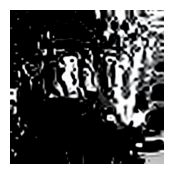

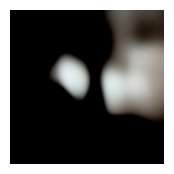

 35%|████▏       | 35/100 [06:55<12:30, 11.55s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a person.']


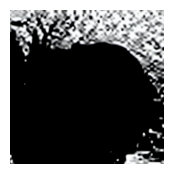

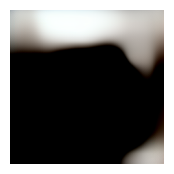

 36%|████▎       | 36/100 [07:07<12:31, 11.74s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a man.']


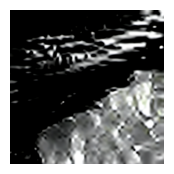

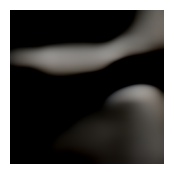

 37%|████▍       | 37/100 [07:19<12:28, 11.88s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is holding a camera.']


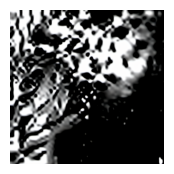

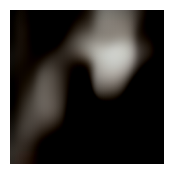

 38%|████▌       | 38/100 [07:31<12:13, 11.83s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large building with a clock on it.']


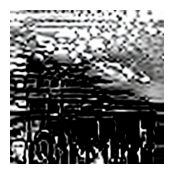

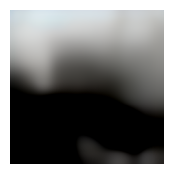

 39%|████▋       | 39/100 [07:43<12:08, 11.94s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


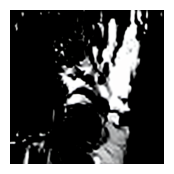

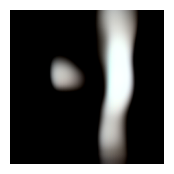

 40%|████▊       | 40/100 [07:55<11:47, 11.80s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


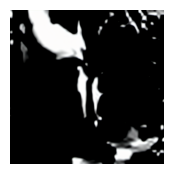

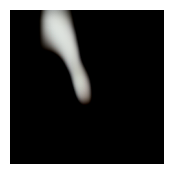

 41%|████▉       | 41/100 [08:06<11:30, 11.70s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in a field.']


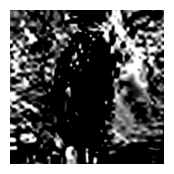

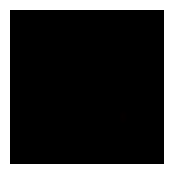

 42%|█████       | 42/100 [08:18<11:23, 11.78s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

["a view of a man's face."]


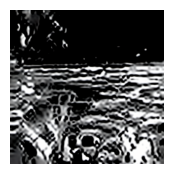

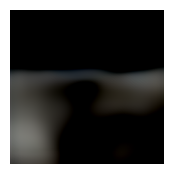

 43%|█████▏      | 43/100 [08:31<11:18, 11.90s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a person.']


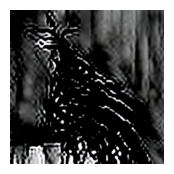

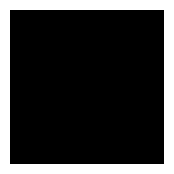

 44%|█████▎      | 44/100 [08:43<11:11, 11.99s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man sitting on a bench.']


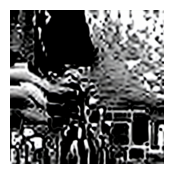

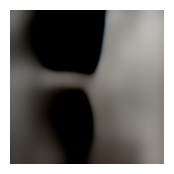

 45%|█████▍      | 45/100 [08:54<10:55, 11.91s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large group of people.']


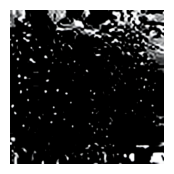

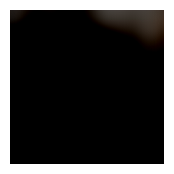

 46%|█████▌      | 46/100 [09:06<10:36, 11.78s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in front of a building.']


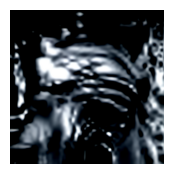

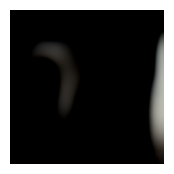

 47%|█████▋      | 47/100 [09:18<10:35, 11.98s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person sitting down.']


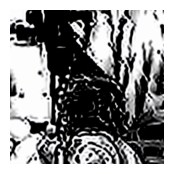

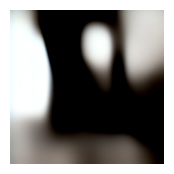

 48%|█████▊      | 48/100 [09:30<10:11, 11.77s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


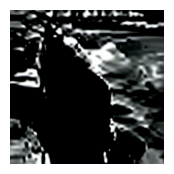

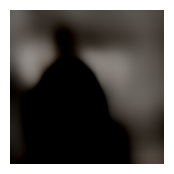

 49%|█████▉      | 49/100 [09:41<09:56, 11.69s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a dog is standing in front of a camera.']


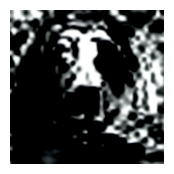

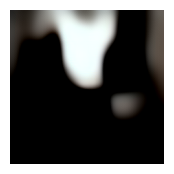

 50%|██████      | 50/100 [09:54<09:56, 11.92s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a tall building with a clock on it.']


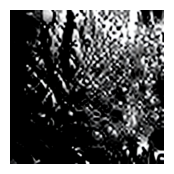

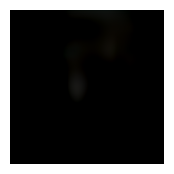

 51%|██████      | 51/100 [10:06<09:48, 12.01s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a woman is holding a camera.']


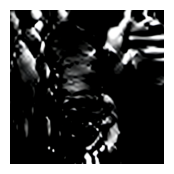

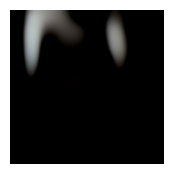

 52%|██████▏     | 52/100 [10:18<09:32, 11.93s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


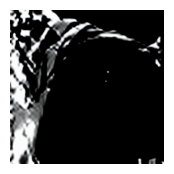

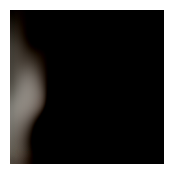

 53%|██████▎     | 53/100 [10:29<09:14, 11.80s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large building with a clock on it.']


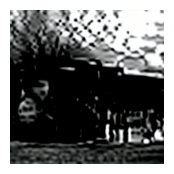

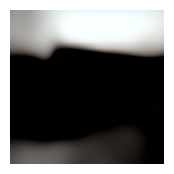

 54%|██████▍     | 54/100 [10:41<09:08, 11.93s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white image of a person.']


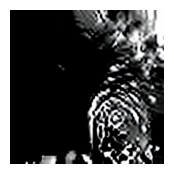

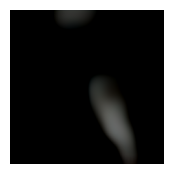

 55%|██████▌     | 55/100 [10:54<09:04, 12.09s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white image of a person.']


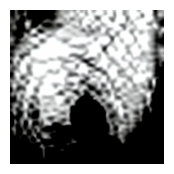

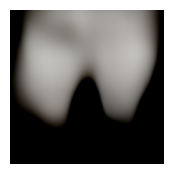

 56%|██████▋     | 56/100 [11:06<08:57, 12.21s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a group of people standing around.']


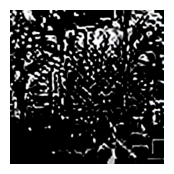

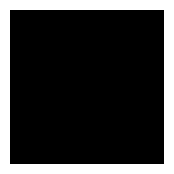

 57%|██████▊     | 57/100 [11:18<08:39, 12.08s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in a room.']


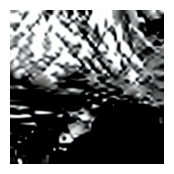

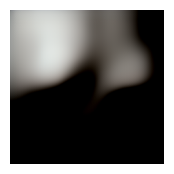

 58%|██████▉     | 58/100 [11:30<08:23, 11.99s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man in a hat.']


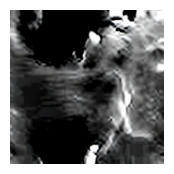

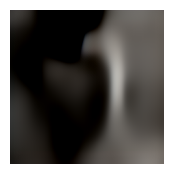

 59%|███████     | 59/100 [11:41<08:06, 11.85s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man sitting down in a chair.']


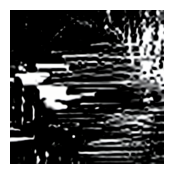

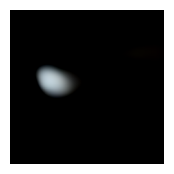

 60%|███████▏    | 60/100 [11:53<07:56, 11.91s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


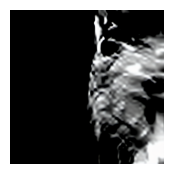

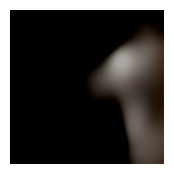

 61%|███████▎    | 61/100 [12:05<07:40, 11.80s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is sitting down.']


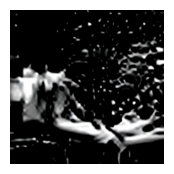

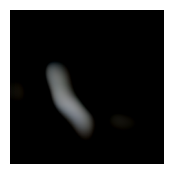

 62%|███████▍    | 62/100 [12:16<07:25, 11.72s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a group of people standing around.']


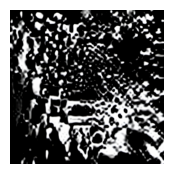

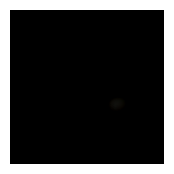

 63%|███████▌    | 63/100 [12:28<07:14, 11.74s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a person.']


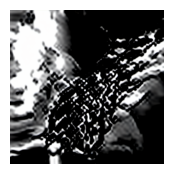

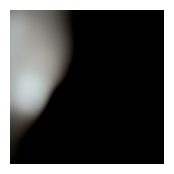

 64%|███████▋    | 64/100 [12:41<07:08, 11.90s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is sitting down.']


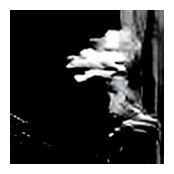

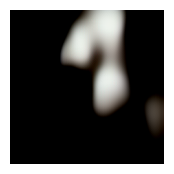

 65%|███████▊    | 65/100 [12:52<06:52, 11.79s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large group of people.']


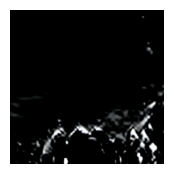

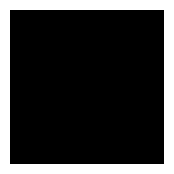

 66%|███████▉    | 66/100 [13:04<06:39, 11.74s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person sitting down.']


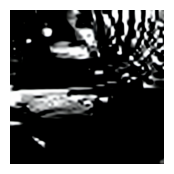

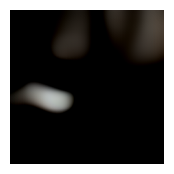

 67%|████████    | 67/100 [13:15<06:23, 11.61s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person standing in front of a camera.']


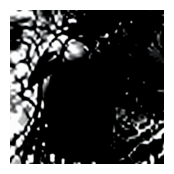

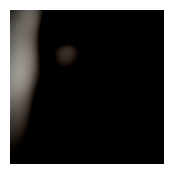

 68%|████████▏   | 68/100 [13:27<06:18, 11.82s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person standing in a field.']


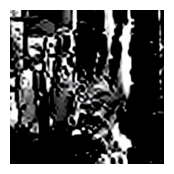

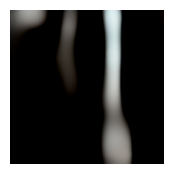

 69%|████████▎   | 69/100 [13:39<06:06, 11.82s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is sitting down.']


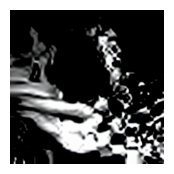

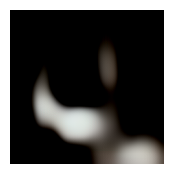

 70%|████████▍   | 70/100 [13:51<05:52, 11.75s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in front of a building.']


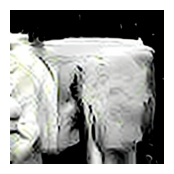

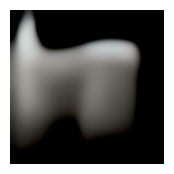

 71%|████████▌   | 71/100 [14:03<05:47, 11.99s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a car is parked on the side of the road.']


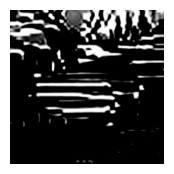

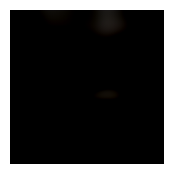

 72%|████████▋   | 72/100 [14:16<05:42, 12.23s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white photo of a man.']


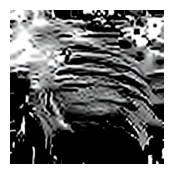

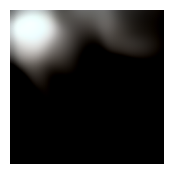

 73%|████████▊   | 73/100 [14:29<05:32, 12.32s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white photo of a person.']


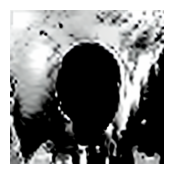

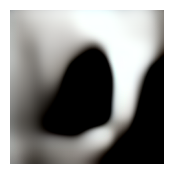

 74%|████████▉   | 74/100 [14:41<05:22, 12.39s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a woman is standing in front of a building.']


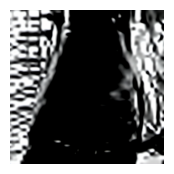

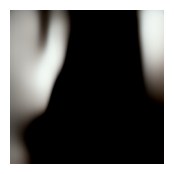

 75%|█████████   | 75/100 [14:54<05:10, 12.43s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


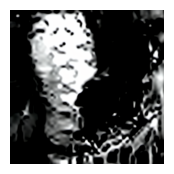

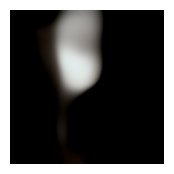

 76%|█████████   | 76/100 [15:05<04:52, 12.18s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in front of a building.']


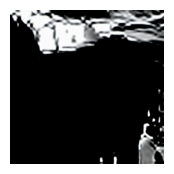

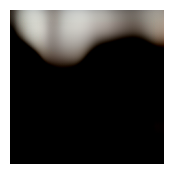

 77%|█████████▏  | 77/100 [15:18<04:40, 12.22s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man sitting down.']


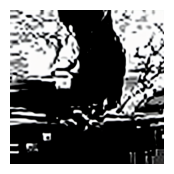

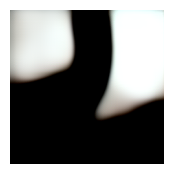

 78%|█████████▎  | 78/100 [15:29<04:23, 11.96s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


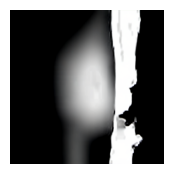

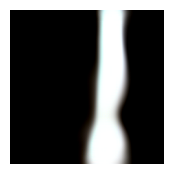

 79%|█████████▍  | 79/100 [15:40<04:08, 11.85s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in front of a camera.']


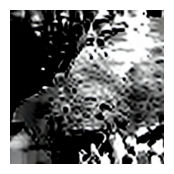

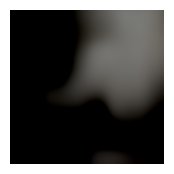

 80%|█████████▌  | 80/100 [15:53<04:01, 12.07s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in a field.']


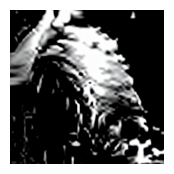

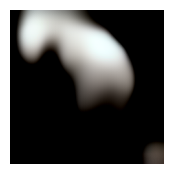

 81%|█████████▋  | 81/100 [16:05<03:49, 12.07s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large white and black building.']


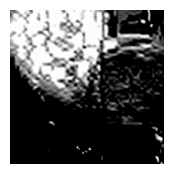

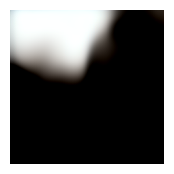

 82%|█████████▊  | 82/100 [16:17<03:36, 12.00s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in front of a camera.']


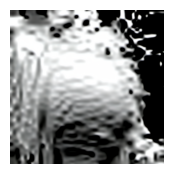

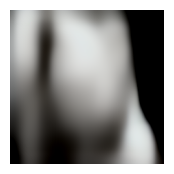

 83%|█████████▉  | 83/100 [16:30<03:26, 12.17s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white photo of a person.']


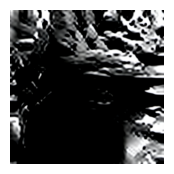

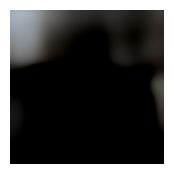

 84%|██████████  | 84/100 [16:42<03:16, 12.30s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a person.']


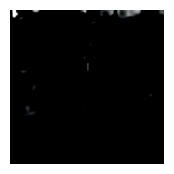

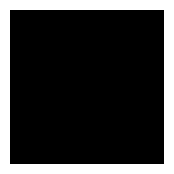

 85%|██████████▏ | 85/100 [16:54<03:04, 12.31s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is sitting down.']


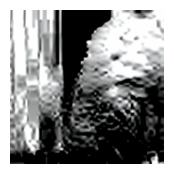

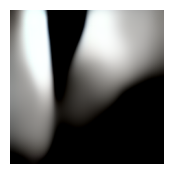

 86%|██████████▎ | 86/100 [17:06<02:49, 12.11s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man sitting down in a chair.']


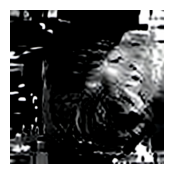

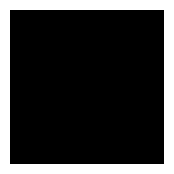

 87%|██████████▍ | 87/100 [17:18<02:37, 12.10s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white image of a person.']


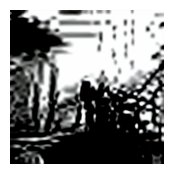

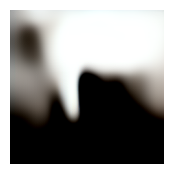

 88%|██████████▌ | 88/100 [17:31<02:26, 12.25s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in a field.']


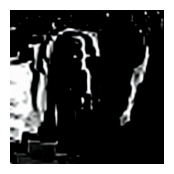

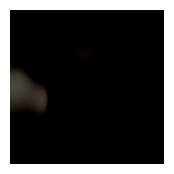

 89%|██████████▋ | 89/100 [17:43<02:13, 12.13s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in front of a building.']


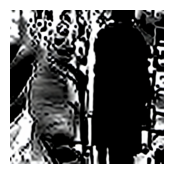

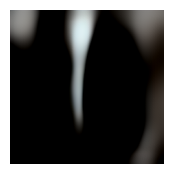

 90%|██████████▊ | 90/100 [17:55<02:01, 12.20s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a car is parked on the side of the road.']


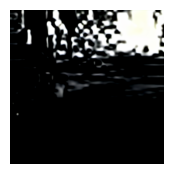

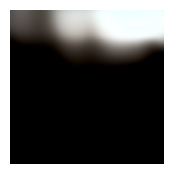

 91%|██████████▉ | 91/100 [18:08<01:51, 12.39s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white animal.']


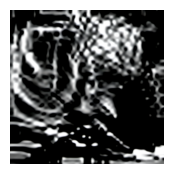

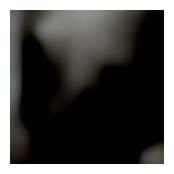

 92%|███████████ | 92/100 [18:20<01:37, 12.24s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in front of a building.']


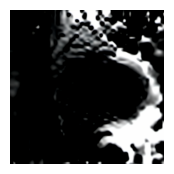

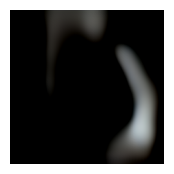

 93%|███████████▏| 93/100 [18:32<01:26, 12.35s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing next to a woman.']


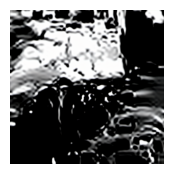

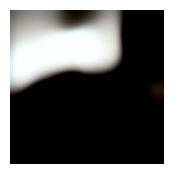

 94%|███████████▎| 94/100 [18:44<01:13, 12.29s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man in a suit and tie.']


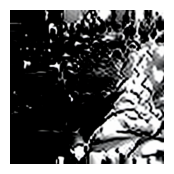

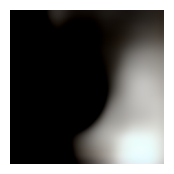

 95%|███████████▍| 95/100 [18:57<01:01, 12.24s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large group of people.']


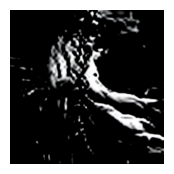

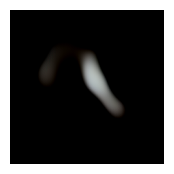

 96%|███████████▌| 96/100 [19:08<00:48, 12.06s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


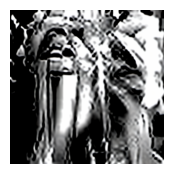

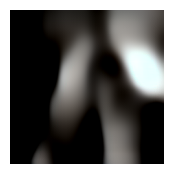

 97%|███████████▋| 97/100 [19:20<00:35, 11.94s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large group of people.']


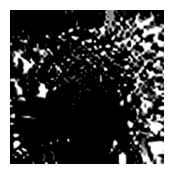

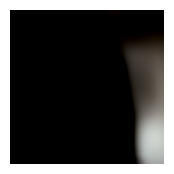

 98%|███████████▊| 98/100 [19:32<00:23, 11.86s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a group of people.']


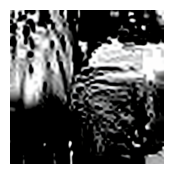

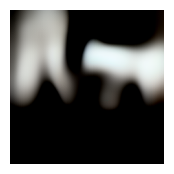

 99%|███████████▉| 99/100 [19:43<00:11, 11.73s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in a field.']


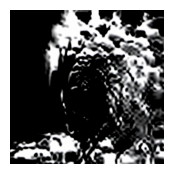

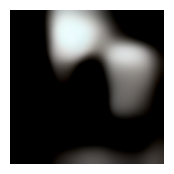

100%|███████████| 100/100 [19:55<00:00, 11.96s/it]
/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([100, 3, 256, 256])
saved csng_mouse_v1__03-04-25_16-06 outputs!


In [12]:
# get all reconstructions
model.to(cfg["device"])
model.eval().requires_grad_(False)

all_blurryrecons = None
all_recons = None
all_predcaptions = []
all_clipvoxels = None

minibatch_size = 1
num_samples_per_image = 1

if utils.is_interactive(): plotting=True

seed_all(cfg["seed"])
with torch.no_grad():
    for start_idx in tqdm(range(0,len(images),minibatch_size)):
        voxel = voxels[subj_name][start_idx:start_idx + minibatch_size].unsqueeze(1).to(cfg["device"])

        # voxel_ridge = model.ridge(voxel, 0) # 0th index of subj_list
        voxel_ridge = model.ridge(voxel, subj_list_idx)
        torch.cuda.empty_cache()
        backbone, clip_voxels, blurry_image_enc = model.backbone(voxel_ridge)
        blurry_image_enc = blurry_image_enc[0]
                
        # Save retrieval submodule outputs
        if all_clipvoxels is None:
            all_clipvoxels = clip_voxels.cpu()
        else:
            all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))
        
        # Feed voxels through OpenCLIP-bigG diffusion prior
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20)
        
        pred_caption_emb = clip_convert(prior_out.to(clip_convert.linear1.weight.device, clip_convert.linear1.weight.dtype))
        generated_ids = clip_text_model.generate(pixel_values=pred_caption_emb, max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        all_predcaptions = np.hstack((all_predcaptions, generated_caption))
        print(generated_caption)
        
        ### feed diffusion prior outputs through unCLIP
        for i in range(len(voxel)):
            assert images.amin() < 0 or images.amax() > 1
            samples = utils.unclip_recon(
                prior_out[[i]],
                diffusion_engine,
                vector_suffix,
                num_samples=num_samples_per_image,
                clamp=False, # to [0, 1]
            )
            if all_recons is None:
                all_recons = samples.cpu()
            else:
                all_recons = torch.vstack((all_recons, samples.cpu()))
            if plotting:
                for s in range(num_samples_per_image):
                    plt.figure(figsize=(2,2))
                    # plt.imshow(transforms.ToPILImage()(samples[s]))
                    plt.imshow(samples[s].cpu().permute(1,2,0).to(torch.float32))
                    plt.axis('off')
                    plt.show()

        if cfg["model"]["blurry_recon"]:
            # blurred_image = (autoenc.decode(blurry_image_enc/0.18215).sample/ 2 + 0.5).clamp(0,1)
            blurred_image = autoenc.decode(blurry_image_enc/0.18215).sample # already z-scored
            
            for i in range(len(voxel)):
                im = torch.Tensor(blurred_image[i])
                if all_blurryrecons is None:
                    all_blurryrecons = im[None].cpu()
                else:
                    all_blurryrecons = torch.vstack((all_blurryrecons, im[None].cpu()))
                if plotting:
                    plt.figure(figsize=(2,2))
                    # plt.imshow(transforms.ToPILImage()(im))
                    plt.imshow(im.cpu().permute(1,2,0).to(torch.float32))
                    plt.axis('off')
                    plt.show()

# resize outputs before saving
imsize = 256
all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
if cfg["model"]["blurry_recon"]: 
    all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()

# saving
print(all_recons.shape)
torch.save(img_tform(images), f"{cfg['model']['evalsdir']}/{subj_name}_{data_tier}_all_images.pt")
torch.save(images, f"{cfg['model']['evalsdir']}/{subj_name}_{data_tier}_all_images_before_transform.pt")
torch.save(voxels,f"{cfg['model']['evalsdir']}/{subj_name}_{data_tier}_all_voxels.pt") 
if cfg["model"]["blurry_recon"]:
    torch.save(all_blurryrecons, f"{cfg['model']['evalsdir']}/{subj_name}_{data_tier}_all_blurryrecons.pt")
torch.save(all_recons, f"{cfg['model']['evalsdir']}/{subj_name}_{data_tier}_all_recons.pt")
torch.save(all_predcaptions, f"{cfg['model']['evalsdir']}/{subj_name}_{data_tier}_all_predcaptions.pt")
torch.save(all_clipvoxels, f"{cfg['model']['evalsdir']}/{subj_name}_{data_tier}_all_clipvoxels.pt")
torch.save(cfg, f"{cfg['model']['evalsdir']}/cfg.pt")
print(f"saved {cfg['model']['model_name']} outputs!")

if not utils.is_interactive():
    sys.exit(0)